# Predicting Student Performance in Secondary Education
**Team Members:** Abby Skillestad and Miles Mercer  
**Course:** CPSC 322, Fall 2025

## Dataset Description
The dataset contains student academic performance data from two Portuguese secondary schools. It includes demographic, social, and school-related variables, along with three grade measurements (G1, G2, G3). Each instance represents a single student. The dataset is multivariate with 649 instances and 30 features.

### Source:
**Dataset:** UCI Machine Learning Repository – Student Performance Dataset  
**Link:** https://archive.ics.uci.edu/dataset/320/student+performance  
**Format:** CSV file (`student-mat.csv`)  
**Contents:** This file contains student attributes such as demographics, parental background, lifestyle, study habits, and academic performance (G1, G2, G3).

### Attributes and Target Variable:
The dataset includes categorical and numeric variables describing a student’s background and school life (e.g., age, parents’ education, family size, study time, absences).  
**Target Variable:**  
- **G3** (final grade), used for classification (predict pass/fail or grade categories).

### UCI Import:

In [55]:
# import ucimlrepo dataset - according to their documentation at https://pypi.org/project/ucimlrepo/
from ucimlrepo import fetch_ucirepo

# fetch dataset
student_performance = fetch_ucirepo(id=320)

# data (as pandas dataframes)
X = student_performance.data.features
y = student_performance.data.targets

# metadata
print(student_performance.metadata)

# variable information
print(student_performance.variables)

{'uci_id': 320, 'name': 'Student Performance', 'repository_url': 'https://archive.ics.uci.edu/dataset/320/student+performance', 'data_url': 'https://archive.ics.uci.edu/static/public/320/data.csv', 'abstract': 'Predict student performance in secondary education (high school). ', 'area': 'Social Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 649, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': ['Sex', 'Age', 'Other', 'Education Level', 'Occupation'], 'target_col': ['G1', 'G2', 'G3'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5TG7T', 'creators': ['Paulo Cortez'], 'intro_paper': {'ID': 360, 'type': 'NATIVE', 'title': 'Using data mining to predict secondary school student performance', 'authors': 'P. Cortez, A. M. G. Silva', 'venue': 'Proceedings of 5th Annual Future Business Technolo

In [56]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import csv

# Add mysklearn to path
sys.path.insert(0, os.path.join(os.getcwd(), "mysklearn"))

from mysklearn.mypytable import MyPyTable
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDecisionTreeClassifier, MyDummyClassifier
from mysklearn.myevaluation import train_test_split, kfold_split, stratified_kfold_split
from mysklearn.myevaluation import confusion_matrix, accuracy_score, classification_report
from mysklearn import myutils

# Load the dataset with semicolon delimiter
data_table = MyPyTable()

# Manual load with correct delimiter
with open("data/student-mat.csv", "r", encoding="utf-8") as infile:
    reader = csv.reader(infile, delimiter=';')
    data_table.column_names = next(reader)
    data_table.data = list(reader)

# Convert to numeric where possible
data_table.convert_to_numeric()

# Get shape manually
n_rows = len(data_table.data)
n_cols = len(data_table.column_names)

print(f"Dataset shape: ({n_rows}, {n_cols})")
print(f"Column names ({n_cols} total):")
print(data_table.column_names)
print(f"\nFirst 3 rows (first 10 columns shown):")
for i in range(min(3, len(data_table.data))):
    print(data_table.data[i][:10], "...")

Dataset shape: (395, 33)
Column names (33 total):
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']

First 3 rows (first 10 columns shown):
['GP', 'F', 18.0, 'U', 'GT3', 'A', 4.0, 4.0, 'at_home', 'teacher'] ...
['GP', 'F', 17.0, 'U', 'GT3', 'T', 1.0, 1.0, 'at_home', 'other'] ...
['GP', 'F', 15.0, 'U', 'LE3', 'T', 1.0, 1.0, 'at_home', 'other'] ...


### Converting G3 to Pass/Fail Classification
We convert the final grade (G3) from a numeric scale (0-20) to a binary classification:
- **Pass**: G3 ≥ 10
- **Fail**: G3 < 10

This aligns with the grading system where 10/20 is the minimum passing grade.

In [57]:
# Create pass/fail labels from G3
g3_index = data_table.column_names.index("G3")
pass_fail_labels = []

for row in data_table.data:
    if row[g3_index] >= 10:
        pass_fail_labels.append("pass")
    else:
        pass_fail_labels.append("fail")

# Add pass/fail column to the table
data_table.column_names.append("pass_fail")
for i, row in enumerate(data_table.data):
    row.append(pass_fail_labels[i])

# Check class distribution
pass_count = pass_fail_labels.count("pass")
fail_count = pass_fail_labels.count("fail")
print(f"Class Distribution:")
print(f"  Pass: {pass_count} ({pass_count/len(pass_fail_labels)*100:.1f}%)")
print(f"  Fail: {fail_count} ({fail_count/len(pass_fail_labels)*100:.1f}%)")

Class Distribution:
  Pass: 265 (67.1%)
  Fail: 130 (32.9%)


## Exploratory Data Analysis

### Summary Statistics
We begin by computing summary statistics for the numeric attributes in our dataset.

In [58]:
# Get numeric columns for summary statistics
numeric_cols = ["age", "Medu", "Fedu", "traveltime", "studytime", "failures", 
                "famrel", "freetime", "goout", "Dalc", "Walc", "health", "absences",
                "G1", "G2", "G3"]

summary_stats = data_table.compute_summary_statistics(numeric_cols)

print("Summary Statistics:")
print(f"{'Attribute':<15} {'Min':<8} {'Max':<8} {'Mid':<8} {'Avg':<8} {'Median':<8}")
print("-" * 70)
for row in summary_stats.data:
    print(f"{row[0]:<15} {row[1]:<8.2f} {row[2]:<8.2f} {row[3]:<8.2f} {row[4]:<8.2f} {row[5]:<8.2f}")

Summary Statistics:
Attribute       Min      Max      Mid      Avg      Median  
----------------------------------------------------------------------
age             15.00    22.00    18.50    16.70    17.00   
Medu            0.00     4.00     2.00     2.75     3.00    
Fedu            0.00     4.00     2.00     2.52     2.00    
traveltime      1.00     4.00     2.50     1.45     1.00    
studytime       1.00     4.00     2.50     2.04     2.00    
failures        0.00     3.00     1.50     0.33     0.00    
famrel          1.00     5.00     3.00     3.94     4.00    
freetime        1.00     5.00     3.00     3.24     3.00    
goout           1.00     5.00     3.00     3.11     3.00    
Dalc            1.00     5.00     3.00     1.48     1.00    
Walc            1.00     5.00     3.00     2.29     2.00    
health          1.00     5.00     3.00     3.55     4.00    
absences        0.00     75.00    37.50    5.71     4.00    
G1              3.00     19.00    11.00    10.91    11.

### Figure 1: Final Grade (G3) Distribution
This histogram shows the distribution of final grades. We can see the overall performance pattern and how grades cluster around certain values.

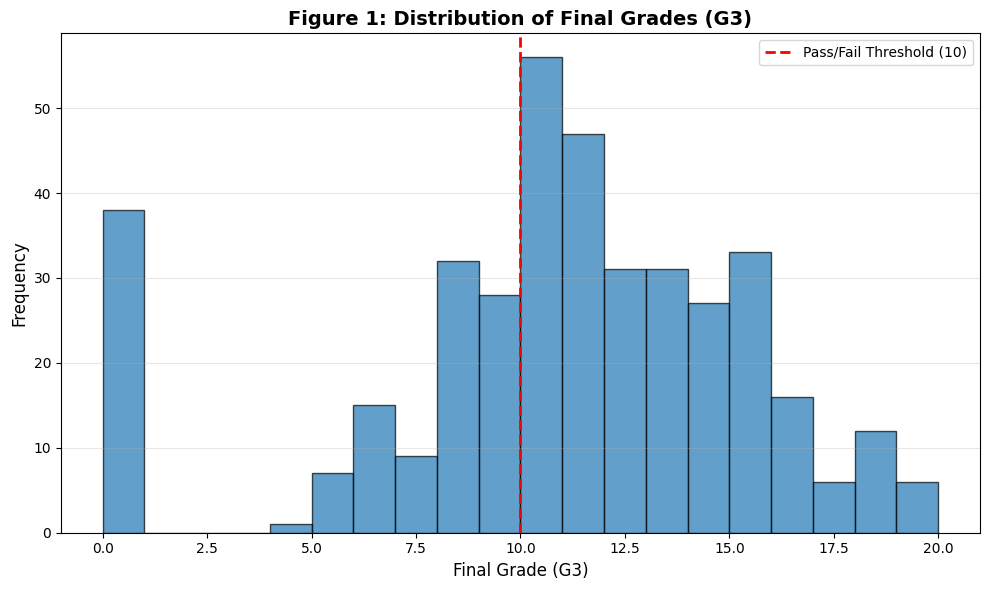

Figure 1 shows the distribution of final grades with a clear pass/fail threshold at grade 10.


In [59]:
# Create histogram for G3
g3_values = data_table.get_column("G3", include_missing_values=False)

plt.figure(figsize=(10, 6))
plt.hist(g3_values, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='Pass/Fail Threshold (10)')
plt.xlabel('Final Grade (G3)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Figure 1: Distribution of Final Grades (G3)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('output/grade_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure 1 shows the distribution of final grades with a clear pass/fail threshold at grade 10.")

### Figure 2: Pass/Fail by Study Time
This visualization explores the relationship between weekly study time and student success. Study time is coded as: 1 (<2 hours), 2 (2-5 hours), 3 (5-10 hours), 4 (>10 hours).

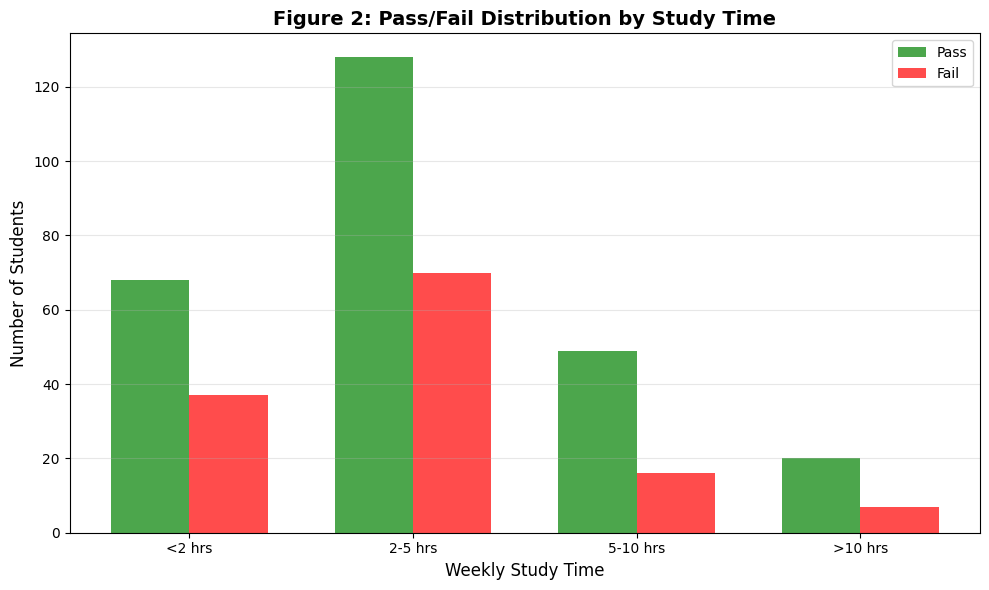

Figure 2 demonstrates how study time correlates with pass/fail outcomes.


In [60]:
# Analyze pass/fail rates by study time
studytime_index = data_table.column_names.index("studytime")
pass_fail_index = data_table.column_names.index("pass_fail")

studytime_pass_fail = {1: {"pass": 0, "fail": 0},
                       2: {"pass": 0, "fail": 0},
                       3: {"pass": 0, "fail": 0},
                       4: {"pass": 0, "fail": 0}}

for row in data_table.data:
    st = int(row[studytime_index])
    pf = row[pass_fail_index]
    studytime_pass_fail[st][pf] += 1

# Create grouped bar chart
study_times = [1, 2, 3, 4]
pass_counts = [studytime_pass_fail[st]["pass"] for st in study_times]
fail_counts = [studytime_pass_fail[st]["fail"] for st in study_times]

x = np.arange(len(study_times))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, pass_counts, width, label='Pass', color='green', alpha=0.7)
bars2 = ax.bar(x + width/2, fail_counts, width, label='Fail', color='red', alpha=0.7)

ax.set_xlabel('Weekly Study Time', fontsize=12)
ax.set_ylabel('Number of Students', fontsize=12)
ax.set_title('Figure 2: Pass/Fail Distribution by Study Time', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['<2 hrs', '2-5 hrs', '5-10 hrs', '>10 hrs'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('output/studytime_vs_grade.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 2 demonstrates how study time correlates with pass/fail outcomes.")

### Figure 3: Impact of Parent Education on Student Success
We examine how parental education levels (both mother and father) influence student pass rates. Education levels: 0 (none), 1 (primary/4th grade), 2 (5th-9th grade), 3 (secondary), 4 (higher education).

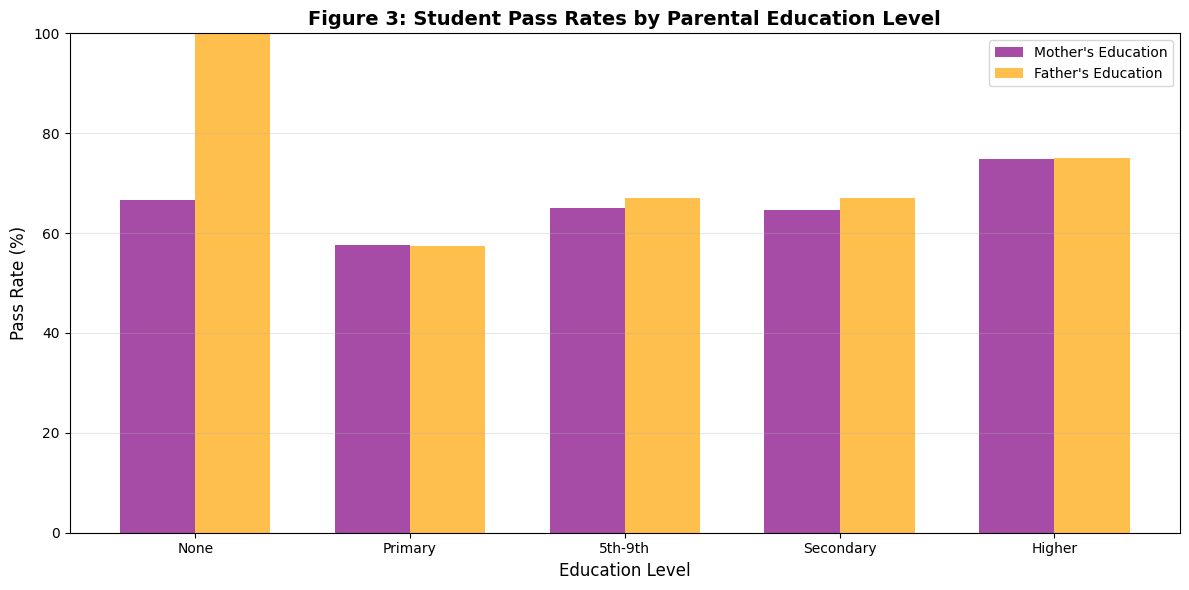

Figure 3 reveals the correlation between parental education and student success rates.


In [61]:
# Analyze parental education impact
medu_index = data_table.column_names.index("Medu")
fedu_index = data_table.column_names.index("Fedu")

medu_pass_rates = {}
fedu_pass_rates = {}

for edu_level in range(5):
    medu_pass_rates[edu_level] = {"pass": 0, "total": 0}
    fedu_pass_rates[edu_level] = {"pass": 0, "total": 0}

for row in data_table.data:
    medu = int(row[medu_index])
    fedu = int(row[fedu_index])
    pf = row[pass_fail_index]
    
    medu_pass_rates[medu]["total"] += 1
    fedu_pass_rates[fedu]["total"] += 1
    
    if pf == "pass":
        medu_pass_rates[medu]["pass"] += 1
        fedu_pass_rates[fedu]["pass"] += 1

# Calculate pass rates
medu_rates = [medu_pass_rates[i]["pass"] / medu_pass_rates[i]["total"] * 100 
              if medu_pass_rates[i]["total"] > 0 else 0 for i in range(5)]
fedu_rates = [fedu_pass_rates[i]["pass"] / fedu_pass_rates[i]["total"] * 100 
              if fedu_pass_rates[i]["total"] > 0 else 0 for i in range(5)]

# Plot
x = np.arange(5)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, medu_rates, width, label="Mother's Education", color='purple', alpha=0.7)
bars2 = ax.bar(x + width/2, fedu_rates, width, label="Father's Education", color='orange', alpha=0.7)

ax.set_xlabel('Education Level', fontsize=12)
ax.set_ylabel('Pass Rate (%)', fontsize=12)
ax.set_title('Figure 3: Student Pass Rates by Parental Education Level', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['None', 'Primary', '5th-9th', 'Secondary', 'Higher'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 100])

plt.tight_layout()
plt.savefig('output/parent_education_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 3 reveals the correlation between parental education and student success rates.")

### Figure 4: Impact of Past Failures
This analysis examines how previous class failures affect final outcomes. The 'failures' attribute represents the number of past class failures (capped at 4 for values ≥3).

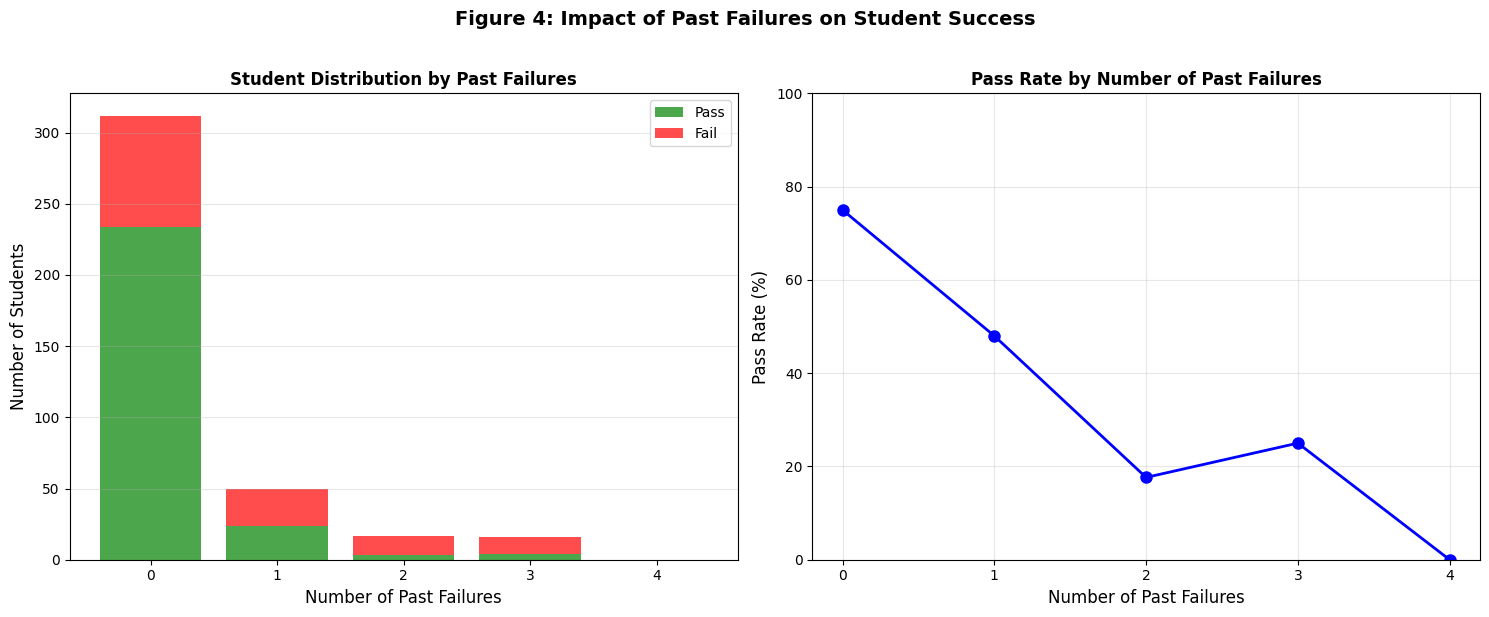

Figure 4 shows a strong negative correlation between past failures and current success.


In [62]:
# Analyze impact of past failures
failures_index = data_table.column_names.index("failures")

failures_distribution = {}
for i in range(5):
    failures_distribution[i] = {"pass": 0, "fail": 0}

for row in data_table.data:
    num_failures = int(row[failures_index])
    pf = row[pass_fail_index]
    failures_distribution[num_failures][pf] += 1

# Create visualization
failures_values = list(failures_distribution.keys())
pass_counts = [failures_distribution[f]["pass"] for f in failures_values]
fail_counts = [failures_distribution[f]["fail"] for f in failures_values]

# Calculate pass rates
pass_rates = [pass_counts[i] / (pass_counts[i] + fail_counts[i]) * 100 
              if (pass_counts[i] + fail_counts[i]) > 0 else 0 
              for i in range(len(failures_values))]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Stacked bar chart
x = np.arange(len(failures_values))
ax1.bar(x, pass_counts, label='Pass', color='green', alpha=0.7)
ax1.bar(x, fail_counts, bottom=pass_counts, label='Fail', color='red', alpha=0.7)
ax1.set_xlabel('Number of Past Failures', fontsize=12)
ax1.set_ylabel('Number of Students', fontsize=12)
ax1.set_title('Student Distribution by Past Failures', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(failures_values)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Pass rate line chart
ax2.plot(failures_values, pass_rates, marker='o', linewidth=2, markersize=8, color='blue')
ax2.set_xlabel('Number of Past Failures', fontsize=12)
ax2.set_ylabel('Pass Rate (%)', fontsize=12)
ax2.set_title('Pass Rate by Number of Past Failures', fontsize=12, fontweight='bold')
ax2.set_xticks(failures_values)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 100])

plt.suptitle('Figure 4: Impact of Past Failures on Student Success', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('output/failures_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 4 shows a strong negative correlation between past failures and current success.")

### Figure 5: Correlation Between Period Grades
As noted in the dataset documentation, G1 (first period) and G2 (second period) grades are highly correlated with G3 (final grade). We visualize this relationship to understand the challenge of predicting G3 without prior grade information.

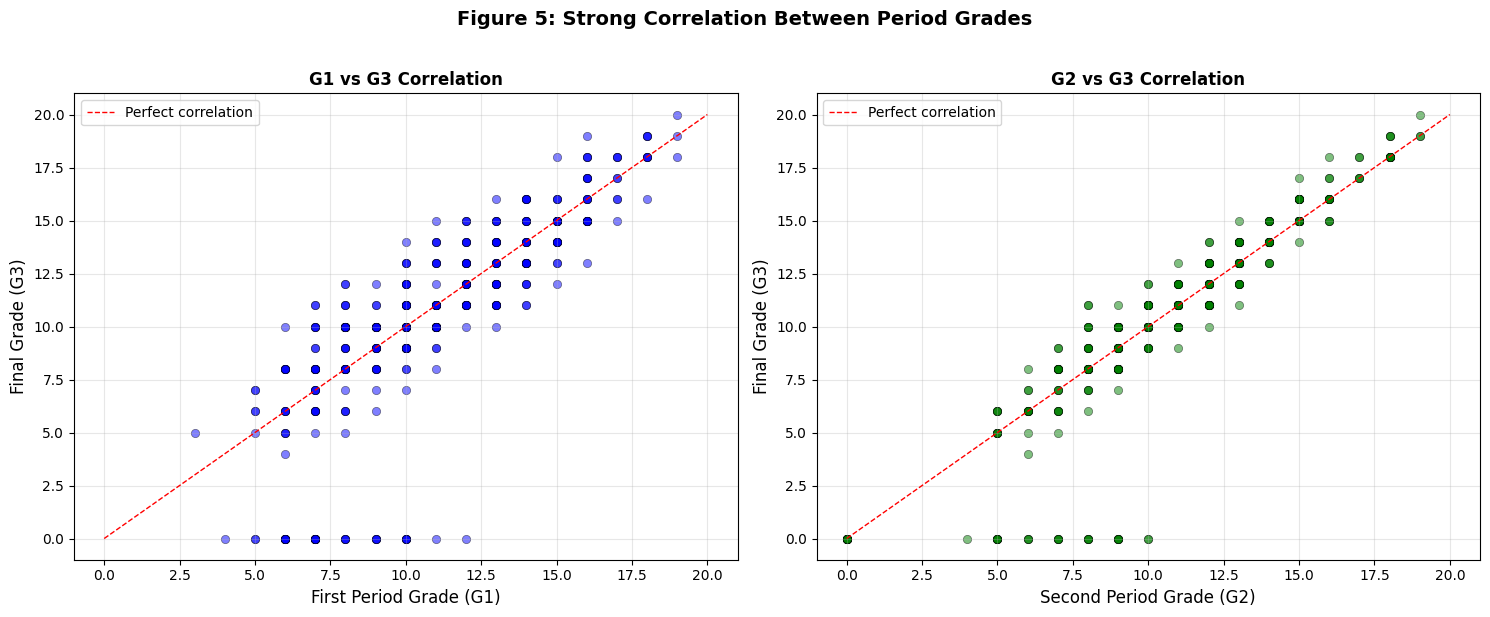

Figure 5 demonstrates the high correlation between G1, G2, and G3.
This makes prediction easier WITH G1/G2 but less realistic/useful.


In [63]:
# Scatter plots for G1, G2 vs G3
g1_values = data_table.get_column("G1", include_missing_values=False)
g2_values = data_table.get_column("G2", include_missing_values=False)
g3_values = data_table.get_column("G3", include_missing_values=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# G1 vs G3
ax1.scatter(g1_values, g3_values, alpha=0.5, c='blue', edgecolors='black', linewidths=0.5)
ax1.set_xlabel('First Period Grade (G1)', fontsize=12)
ax1.set_ylabel('Final Grade (G3)', fontsize=12)
ax1.set_title('G1 vs G3 Correlation', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.plot([0, 20], [0, 20], 'r--', linewidth=1, label='Perfect correlation')
ax1.legend()

# G2 vs G3
ax2.scatter(g2_values, g3_values, alpha=0.5, c='green', edgecolors='black', linewidths=0.5)
ax2.set_xlabel('Second Period Grade (G2)', fontsize=12)
ax2.set_ylabel('Final Grade (G3)', fontsize=12)
ax2.set_title('G2 vs G3 Correlation', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.plot([0, 20], [0, 20], 'r--', linewidth=1, label='Perfect correlation')
ax2.legend()

plt.suptitle('Figure 5: Strong Correlation Between Period Grades', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('output/grade_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 5 demonstrates the high correlation between G1, G2, and G3.")
print("This makes prediction easier WITH G1/G2 but less realistic/useful.")

## Data Preprocessing for Classification

### Feature Selection and Encoding
Following the dataset documentation's recommendation, we build models WITHOUT G1 and G2 to create a more realistic and useful prediction system. We prepare two feature sets for comparison later with the random forest implementation.

We need to encode categorical variables as the classifiers expect numeric inputs. Binary variables (yes/no) are converted to 1/0, and multi-valued categorical variables are kept as-is since our classifiers can handle them.

In [64]:
# Prepare feature matrix X and target vector y
# We'll create X WITHOUT G1 and G2 (more realistic prediction)

# First, encode binary categorical variables
def encode_binary(value):
    """Convert yes/no to 1/0"""
    if value == "yes":
        return 1
    elif value == "no":
        return 0
    return value

# Columns to exclude: G1, G2, G3, pass_fail
exclude_cols = ["G1", "G2", "G3", "pass_fail"]

# Get feature column indices
feature_indices = []
feature_names = []
for i, col_name in enumerate(data_table.column_names):
    if col_name not in exclude_cols:
        feature_indices.append(i)
        feature_names.append(col_name)

print(f"Number of features: {len(feature_names)}")
print(f"Features used: {feature_names}")

# Build X and y
X = []
y = []
pass_fail_index = data_table.column_names.index("pass_fail")

for row in data_table.data:
    # Extract features
    instance = []
    for idx in feature_indices:
        value = row[idx]
        # Encode binary yes/no values
        if value in ["yes", "no"]:
            value = encode_binary(value)
        instance.append(value)
    X.append(instance)
    
    # Extract label
    y.append(row[pass_fail_index])

print(f"\nDataset prepared: {len(X)} instances with {len(X[0])} features each")
print(f"Class distribution: Pass={y.count('pass')}, Fail={y.count('fail')}")

Number of features: 30
Features used: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Dataset prepared: 395 instances with 30 features each
Class distribution: Pass=265, Fail=130


In [65]:
# Identify which features are numeric and need normalization
# Numeric columns (from original): age, Medu, Fedu, traveltime, studytime, failures,
# famrel, freetime, goout, Dalc, Walc, health, absences
numeric_feature_names = ["age", "Medu", "Fedu", "traveltime", "studytime", "failures",
                         "famrel", "freetime", "goout", "Dalc", "Walc", "health", "absences"]

numeric_feature_indices = [feature_names.index(name) for name in numeric_feature_names if name in feature_names]

print(f"Numeric features to normalize: {[feature_names[i] for i in numeric_feature_indices]}")

# Function to normalize data
def normalize_data(X_data):
    """Min-max normalization for numeric features"""
    X_normalized = [row[:] for row in X_data]  # Deep copy
    
    # For each numeric feature
    for feature_idx in numeric_feature_indices:
        # Get all values for this feature
        values = [row[feature_idx] for row in X_data]
        min_val = min(values)
        max_val = max(values)
        
        # Normalize if there's variation
        if max_val > min_val:
            for i in range(len(X_normalized)):
                X_normalized[i][feature_idx] = (X_normalized[i][feature_idx] - min_val) / (max_val - min_val)
    
    return X_normalized

# Create normalized version (we'll use this for k-NN)
X_normalized = normalize_data(X)

print(f"Normalized dataset created with {len(X_normalized)} instances")
print(f"Sample normalized instance (first 5 features): {X_normalized[0][:5]}")

Numeric features to normalize: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Normalized dataset created with 395 instances
Sample normalized instance (first 5 features): ['GP', 'F', 0.42857142857142855, 'U', 'GT3']


## Classification Results

### Evaluation Strategy
We evaluate three classifiers using multiple approaches:
1. **Simple train/test split** (67% train, 33% test)
2. **10-fold cross-validation** (standard approach)
3. **10-fold stratified cross-validation** (maintains class distribution)

For each approach, we compute:
- Accuracy
- Confusion matrix
- Precision, recall, and F1-score
- Classification report

The classifiers evaluated are:
- **Dummy Classifier** (baseline, predicts most frequent class)
- **k-Nearest Neighbors** (with k=5)
- **Decision Tree** (using entropy-based TDIDT)

### Normalizing Numeric Features
For k-NN classifier, we need to normalize numeric features to ensure all attributes contribute equally to distance calculations. We'll use min-max normalization to scale values to [0, 1] range.

In [66]:
# Function to print results nicely
def print_evaluation_results(classifier_name, y_true, y_pred):
    """Print comprehensive evaluation metrics"""
    print(f"\n{'='*70}")
    print(f"{classifier_name}")
    print(f"{'='*70}")
    
    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f} ({acc*100:.2f}%)")
    
    # Confusion Matrix
    labels = sorted(list(set(y_true)))
    cm = confusion_matrix(y_true, y_pred, labels)
    print(f"\nConfusion Matrix:")
    print(f"{'':>10} {labels[0]:>10} {labels[1]:>10}")
    for i, label in enumerate(labels):
        print(f"{label:>10} {cm[i][0]:>10} {cm[i][1]:>10}")
    
    # Classification Report
    print(f"\nClassification Report:")
    report = classification_report(y_true, y_pred, labels=labels)
    print(report)
    
    return acc

# Store all results for comparison
all_results = {
    "Dummy": {"train_test": None, "kfold": None, "stratified": None},
    "kNN": {"train_test": None, "kfold": None, "stratified": None},
    "Decision Tree": {"train_test": None, "kfold": None, "stratified": None}
}

# Citations
UCI Machine Learning Repository. Student Performance Dataset. https://archive.ics.uci.edu/dataset/320/student+performance